# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Read in Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Unpickle preprocessed training data

df_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/ames-housing/Data/train_preprocessed.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Understanding Features

Move to section below feat engg

In [3]:
def heatmap(corr_matrix):
  sns.clustermap(corr_matrix,
                 annot=False,
                 cmap='Blues')
  plt.show()

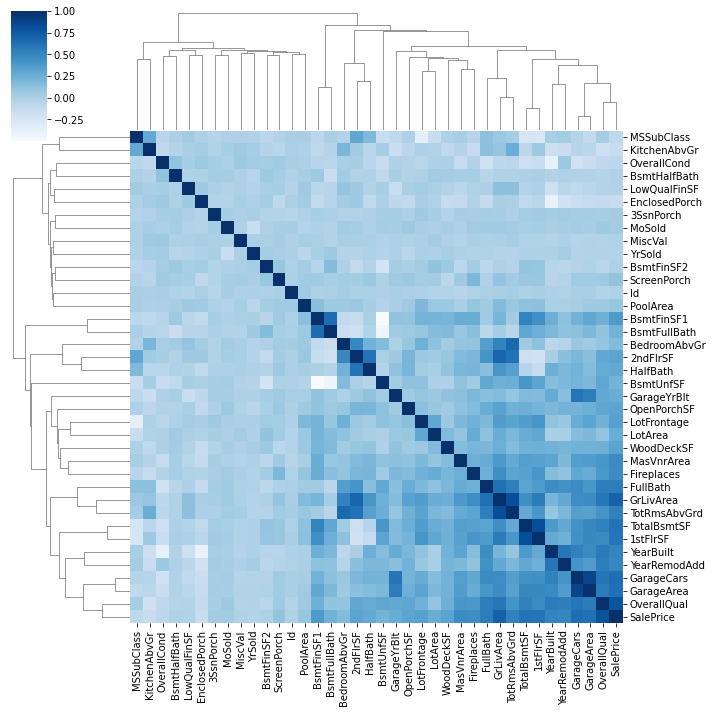

In [4]:
corr1 = df_train.corr()
heatmap(corr1)

This is a lot to look at. Instead find the features that are most strongly correlated to 'SalePrice'

In [5]:
corr2 = df_train.corr()['SalePrice'].sort_values(ascending=False)
corr2

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

# Feature Generation

Some features are overly granular. We can combine these features into a single feature.

* We have seen through EDA that unfinished vs finished surface areas matter less than total surface areas. So keep `'TotalBsmtSF'` and drop `'BsmtFinSF1'`, `'BsmtFinSF2'`, `'BsmtUnfSF'`

* Keep `'GrLivArea'` and drop `'1stFlrSF'`, `'2ndFlrSF'`, `'LowQualFinSF'`.
  * We can also retain `'2ndFlrSF'` by making a new binary variable `'Has2ndFlr'`

* Combine `'BsmtFullBath'` and `'BsmtHalfBath'` into `'BsmtTotalBath'`

* Combine `'FullBath'` and `'HalfBath'` into `'AbvGrTotalBath'`

* Combine `'WoodDeckSF'`, `'OpenPorchSF'`, `'EnclosedPorch'`, `'3SsnPorch'`, `'ScreenPorch'` into `'TotalPorchAr'`

* Note: No changes to features related to the garage

In [6]:
# Take a look at all the columns again

df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# How are the surface area variables related?

df_train[df_train['LowQualFinSF'] != 0][['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea
51,0,0,816,816,816,0,360,1176
88,0,0,1013,1013,1013,0,513,1526
125,490,0,30,520,520,0,234,754
170,360,0,360,720,854,0,528,1382
185,0,0,1107,1107,1518,1518,572,3608


In [8]:
# How are number of bathroom variables related?

df_train[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']]. head()

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
0,1,0,2,1
1,0,1,2,0
2,1,0,2,1
3,1,0,1,0
4,1,0,2,1


In [9]:
# What is the total porch area for the home?

df_train[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].head()

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,0,61,0,0,0
1,298,0,0,0,0
2,0,42,0,0,0
3,0,35,272,0,0
4,192,84,0,0,0


In [10]:
# Can we feature engineer features related to the garage?

df_train[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',]].head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2,548,TA,TA
1,Attchd,1976.0,RFn,2,460,TA,TA
2,Attchd,2001.0,RFn,2,608,TA,TA
3,Detchd,1998.0,Unf,3,642,TA,TA
4,Attchd,2000.0,RFn,3,836,TA,TA


# Feature Transformations

EDA revealed that many features were skewed (i.e. not normally distributed). Here we will use scipy.stats to figure out which features are skewed and apply trasnformations to reduce the skew.

# Create EngineerFeatures object

In [11]:
class EngineerFeatures():

  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None): 
    X_new = X.copy()

    # Feature generation

    X_new['BsmtTotalBath'] = X_new['BsmtFullBath'] + (0.5 * X_new['BsmtHalfBath'])
    X_new['AbvGrTotalBath'] = X_new['FullBath'] + (0.5 * X_new['HalfBath'])
    X_new['TotalPorchAr'] = X_new['WoodDeckSF'] + X_new['OpenPorchSF'] + X_new['EnclosedPorch'] + X_new['3SsnPorch'] + X_new['ScreenPorch'] 
    X_new['Has2ndFlr'] = X_new['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    cols_to_drop = [
        'BsmtFinSF1', 
        'BsmtFinSF2', 
        'BsmtUnfSF',
        '1stFlrSF', 
        '2ndFlrSF', 
        'LowQualFinSF', 
        'BsmtFullBath', 
        'BsmtHalfBath', 
        'FullBath', 
        'HalfBath', 
        'WoodDeckSF', 
        'OpenPorchSF', 
        'EnclosedPorch', 
        '3SsnPorch', 
        'ScreenPorch'
    ]

    X_new = X_new.drop(cols_to_drop, axis=1)

    # Feature trasnformations
    

    return X_new

  def fit_transform(self, X, y=None):
    return self.fit(X).transform(X)

In [12]:
engg = EngineerFeatures()

dfnew = engg.fit_transform(df_train)

dfnew.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolArea', 'PoolQC', 'Fence',
       'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice', 'BsmtTotalBath'